In [1]:
%matplotlib inline

from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#関数の引数を調べる
import inspect
#inspect.signature(f)
#バージョンの確認
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
#Version(sklearn_version)

In [8]:
from scipy.misc import comb
import math
#math.ceilは切り上げ
def emsemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier/ 2.0))
    probs = [comb(n_classifier, k)* error**k* (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier+1)]
    return sum(probs)

In [9]:
emsemble_error(n_classifier=11, error=0.25)

0.034327507019042969

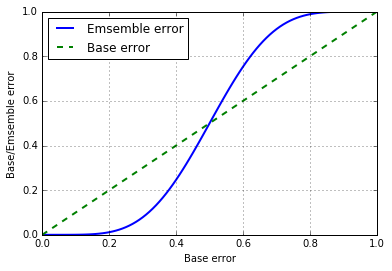

In [12]:
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [emsemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Emsemble error', lw=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', lw=2)
plt.xlabel('Base error')
plt.ylabel('Base/Emsemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [17]:
#重み付き多数決
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

In [15]:
inspect.signature(np.argmax)

<Signature (a, axis=None, out=None)>

In [24]:
ex = np.array([[0.9, 0.1],[0.8, 0.2],[0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2,0.2,0.6])


In [25]:
ex

array([[ 0.9,  0.1],
       [ 0.8,  0.2],
       [ 0.4,  0.6]])

In [26]:
p

array([ 0.58,  0.42])

In [27]:
np.argmax(p)

0

MajorityVoteClassifierクラスを作る

In [93]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """多数決アンサンブル分類器
    
    パラメータ
    ----------------------
    classifiers : array-like, shape=[n_classifiers]
            アンサンブルの様々な分類器
            
    vote : str, {'classlabel', 'probability',} (default: 'classlabel')
            'classlabel'の場合、クラスラベルの予測はクラスラベルのargmaxに基づく
            'probability'の場合、クラスラベルの予測はクラスの所属確率のargmaxに基づく(分類器が調整済みであることが推奨される)
            
    weights : array-like, shape=[n_classifiers] (optional, default=None)
            'int'または'float'型の値のリストが提供された場合、分類器は重要度で重みづけされる
            'weights=None'の場合は均一な重みを使用
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        #推定器のいろいろな情報を取得
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """分類器を学習させる
        
        パラメータ
        -------------------------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
                トレーニングサンプルからなる行列
        y : array-like, shape=[n_samples]
                クラスラベルのベクトル
        
        戻り値
        ---------------------------------
        self : object
              
        """
        #LabelEncoderを使ってクラスラベルが０から始まるようにエンコードする
        #self.predictのnp.argmax呼び出しで重要となる
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            #fitした結果はすべてself.classifiers_に格納
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """Xのクラスラベルを予測する
        パラメータ
        --------------------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
                トレーニングサンプルからなる行列
        
        戻り値
        ---------------------------
        maj_vote : array-like, shape = [n_samples]
                予測されたサンプル
        """
        if self.vote == 'probability':
            #クラスラベルを返す(predict_proba関数は重みを考慮している)
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel'での多数決
            #clf.predict呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            #各サンプルのクラス確率に重みを掛けて足し合わせた値が最大となる
            # 列番号を配列として返す
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        #各サンプルに確率の最大値を与えるクラスラベルを抽出    
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """Xのクラス確率を予想する
         パラメータ
        --------------------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
                トレーニングベクトル: n_samplesはサンプルの個数、n_featuresは特徴量の個数
        
        戻り値
        ---------------------------
        avg_proba : array-like, shape = [n_samples,n_classes]
                各サンプルに対する各クラスで重みつけた平均確率
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        """GridSearchの実行時に分類器のパラメータを取得"""
        if not deep :
            #suoer(クラス名,self).メソッド名でクラス名のスーパークラスのインスタンスを使う
            #今回は BaseEstimatorのget_paramsインスタンス
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            #キーを"分類器の名前__パラメータ名"、バリューをパラメータの値とするディクショナリを生成
            out = self.named_classifiers.copy()
            #six.iteritemsは辞書からkey とvalueを取り出す感じ
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [28]:
from sklearn.ensemble import VotingClassifier

In [45]:
from sklearn.pipeline import _name_estimators
from sklearn.svm import SVC
classifiers = [SVC()]
{key: value for key, value in _name_estimators(classifiers)}

{'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)}

In [32]:
np.argmax(ex,axis=1)

array([0, 0, 1])

In [33]:
ex

array([[ 0.9,  0.1],
       [ 0.8,  0.2],
       [ 0.4,  0.6]])

In [42]:
super(SVC)

<super: sklearn.svm.classes.SVC, None>

In [43]:
class Dog(object):
    def __init__(self, name):
       self.name = name

class UltraDog(Dog):
    def __init__(self, name, type):
        super(UltraDog, self).__init__(name)
        self.type = type

ud1 = UltraDog("taro", "akita")
print(ud1.name)

taro


In [49]:
out = {key: value for key, value in _name_estimators(classifiers)}
out

{'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)}

In [57]:
for name, step in six.iteritems({key: value for key, value in _name_estimators(classifiers)}):
    print(step.get_params(deep=True))
    for key, value in six.iteritems(step.get_params(deep=True)):
        out['%s__%s' % (name, key)] = value
        print(key)
        print(value)
            

{'C': 1.0, 'decision_function_shape': None, 'max_iter': -1, 'tol': 0.001, 'degree': 3, 'random_state': None, 'cache_size': 200, 'probability': False, 'coef0': 0.0, 'class_weight': None, 'gamma': 'auto', 'verbose': False, 'shrinking': True, 'kernel': 'rbf'}
C
1.0
decision_function_shape
None
max_iter
-1
tol
0.001
degree
3
random_state
None
cache_size
200
probability
False
coef0
0.0
class_weight
None
gamma
auto
verbose
False
shrinking
True
kernel
rbf


In [52]:
out

{'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'svc__C': 1.0,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [59]:
SVC().get_params(deep=True)

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [60]:
SVC().get_params(deep=False)

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [132]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [66]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [69]:
le.classes_

array([1, 2])

In [70]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

まずはそれぞれを実行してみる

In [72]:
#croos_val_scoreは交差検証してそれぞれの正解率を返す
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
#max_depth=1は一回しか決定木を分割しないことを意味する　決定株
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
#p=2, metric='minkowski'はユークリッド距離を意味する
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic Regression', 'Decision tree', 'KNN']
print('10-fold cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [94]:
##Majority Voting を実装
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))


ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


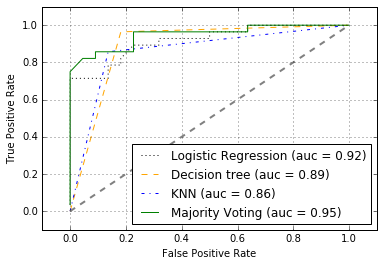

In [76]:
##ROC曲線を描いてみる
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    #陽性クラスのラベルは1であることが前提
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color= clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', lw=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

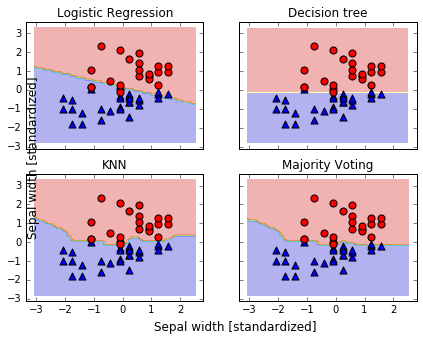

In [134]:
##各分類器の決定領域を調べる
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
#決定領域を描画する最小値、最大値を生成
x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 1].min() -1
y_max = X_train_std[:, 1].max() +1
#グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

#描画領域を2行2列に分割
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize =(7,5))

#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列を表すタプル
#product関数は引数のリストのすべての組み合わせのタプルのリストを返す(meshgridと似てる)
for idx, clf, tt in zip(product([0,1],[0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    #np.c_はcbind
    #すべての点でpredict
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0, 0],X_train_std[y_train==0, 1],
                                                      c ='blue', marker='^', s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1, 0],X_train_std[y_train==1, 1],
                                                      c ='red', marker='o', s=50)
    axarr[idx[0],idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12,rotation=90)
plt.show()

In [79]:
from itertools import product
list(product([0,1],[0,1]))

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [82]:
##各分類器の決定領域を調べる
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
#決定領域を描画する最小値、最大値を生成
x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 0].min() -1
y_max = X_train_std[:, 0].max() +1
#グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [83]:
#np.c_はcbind
np.c_[xx.ravel(), yy.ravel()]

array([[-3.07478921, -3.07478921],
       [-2.97478921, -3.07478921],
       [-2.87478921, -3.07478921],
       ..., 
       [ 2.32521079,  2.52521079],
       [ 2.42521079,  2.52521079],
       [ 2.52521079,  2.52521079]])

In [85]:
xx.shape

(57, 57)

In [86]:
xx

array([[-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079],
       [-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079],
       [-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079],
       ..., 
       [-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079],
       [-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079],
       [-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079]])

In [96]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=

In [97]:
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1,2], 
                   'pipeline-1__clf__C': [0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params,cv=10, scoring='roc_auc' )
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [105]:
#griid_scores_にすべてのパラメータで実行した結果が格納されている(パラメータとスコア)
#scoresには10回分の結果が格納されている
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.3f) for %r" % (mean_score, scores.std(), params))

0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 (+/-0.000) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 (+/-0.000) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [104]:
#griid_scores_にすべてのパラメータで実行した結果が格納されている(パラメータとスコア)
#scoresには10回分の結果が格納されている
for params, mean_score, scores in grid.grid_scores_:
    print(scores)
    #print("%0.3f (+/-%0.3f) for %r" % (mean_score, scores.std(), params))

[ 1.          1.          1.          1.          1.          1.          1.
  0.66666667  1.          1.        ]
[ 1.          1.          1.          1.          1.          1.          1.
  0.66666667  1.          1.        ]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.          1.          1.          1.          1.          1.          1.
  0.66666667  1.          1.        ]
[ 1.          1.          1.          1.          1.          1.          1.
  0.66666667  1.          1.        ]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [100]:
grid.grid_scores_

[mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
 mean: 1.00000, std: 0.00000, params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001},
 mean: 0.96667, std: 0.10000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1},
 mean: 1.00000, std: 0.00000, params: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}]

In [106]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [107]:
print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


バギング

In [135]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [136]:
np.unique(df_wine['Class label'] )

array([1, 2, 3])

In [137]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [138]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [139]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=1)

In [140]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree,n_estimators=500, max_samples=1.0, max_features=1.0,
                                          bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [141]:
#普通に決定木だけ
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [142]:
#バギングする
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.896


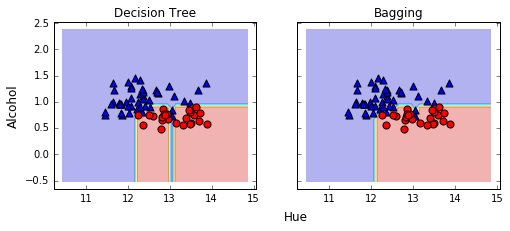

In [143]:
#決定領域を描画する最小値、最大値を生成
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() +1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() +1
#グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

#描画領域を2行2列に分割
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize =(8,3))

#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列を表すタプル
#product関数は引数のリストのすべての組み合わせのタプルのリストを返す(meshgridと似てる)
for idx, clf, tt in zip([0,1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    #np.c_はcbind
    #すべての点でpredict
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],
                                                      c ='blue', marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],
                                                      c ='red', marker='o', s=50)
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

ADABOOST

In [145]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.845/0.854


In [148]:
DecisionTreeClassifier().get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')>

剪定されていない、つまりmax_depth=Noneだと過学習が見られたが、決定株、つまりmax_depth=1だと学習不足になる

In [149]:
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.875


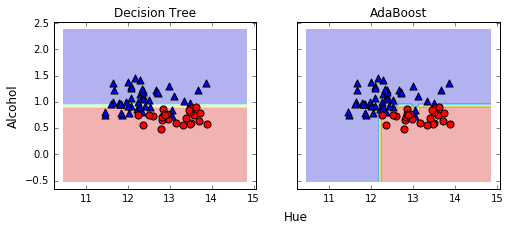

In [150]:
#決定領域を描画する最小値、最大値を生成
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() +1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() +1
#グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

#描画領域を2行2列に分割
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize =(8,3))

#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列を表すタプル
#product関数は引数のリストのすべての組み合わせのタプルのリストを返す(meshgridと似てる)
for idx, clf, tt in zip([0,1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    #np.c_はcbind
    #すべての点でpredict
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],
                                                      c ='blue', marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],
                                                      c ='red', marker='o', s=50)
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()